In [1]:
import pandas as pd

Copied the raw twitter dataset file to HDFS. Then loaded the file in pyspark using databricks. Run few basic commands to understand the fields, data type volume.

In [2]:
tweets = sqlContext.read.format("com.databricks.spark.csv").option("header", "true").load("/user/twitter_dataset/twcs.csv")

In [3]:
tweets.printSchema()
print tweets.count()

root
 |-- tweet_id: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- inbound: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- text: string (nullable = true)
 |-- response_tweet_id: string (nullable = true)
 |-- in_response_to_tweet_id: string (nullable = true)

2849390


Register the dataset as table for quering in sql and cache for better performance

In [4]:
tweets.registerTempTable("tweets")
tweets.cache()


Running basic queries on dataset

In [ ]:
sqlContext.sql("SELECT count(1) as test FROM tweets").show()

In [ ]:
sqlContext.sql("SELECT count(distinct author_id) FROM tweets ").show()

Exploratory Question :- Which are the leaders in response on twitter resolving the customer queries

In [6]:
# Leader orgaization on twitter
topOrgByVolume = sqlContext.sql("SELECT author_id,count(1) as no_of_response FROM tweets where inbound='False' GROUP BY author_id ORDER BY no_of_response DESC limit 10")

In [7]:
topOrgByVolumeDF = topOrgByVolume.toPandas()
print topOrgByVolume.show()


+---------------+--------------+
|      author_id|no_of_response|
+---------------+--------------+
|     AmazonHelp|        163753|
|   AppleSupport|        104523|
|   Uber_Support|         56191|
|   SpotifyCares|         43255|
|          Delta|         42100|
|          Tesco|         37797|
|    AmericanAir|         36748|
|    TMobileHelp|         34023|
|   comcastcares|         32997|
|British_Airways|         29311|
+---------------+--------------+

None


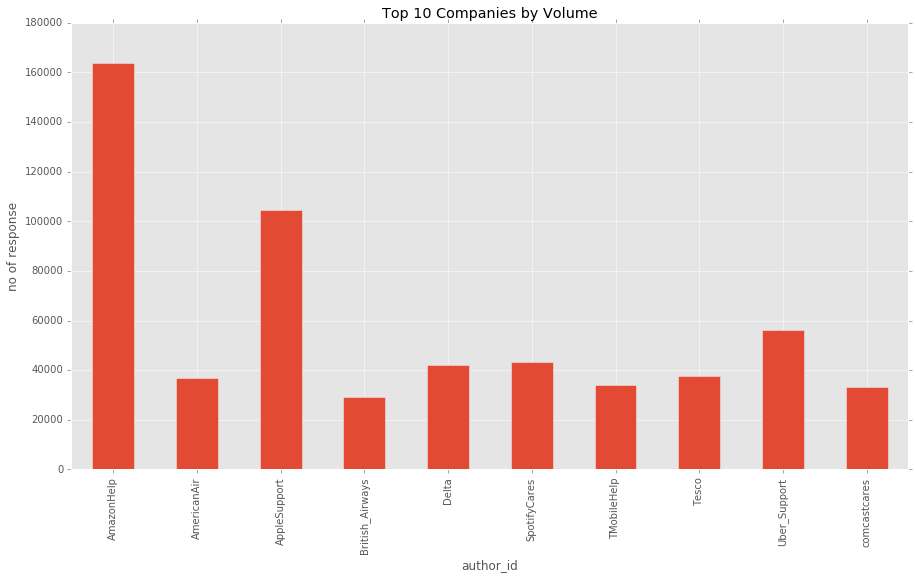

In [8]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

ax = plt.subplot()
ax.set_ylabel('no of response')
ax.set_xlabel('organization')
topOrgByVolumeDF.groupby('author_id').sum()['no_of_response'].plot(kind='bar',figsize=(15,8), title='Top 10 Companies by Volume')


In [10]:
#Bottom 10 organizations by tweets volume
sqlContext.sql("SELECT author_id,count(1) as no_of_response FROM tweets where inbound='False' GROUP BY author_id ORDER BY no_of_response ASC").show(10)

+---------------+--------------+
|      author_id|no_of_response|
+---------------+--------------+
| HotelTonightCX|           152|
|        CarlsJr|           189|
|         AskDSC|           210|
|  OfficeSupport|           218|
|      MTNC_Care|           242|
|        JackBox|           266|
|     OPPOCareIN|           283|
|mediatemplehelp|           297|
|   AskRobinhood|           431|
|     AskSeagate|           506|
+---------------+--------------+
only showing top 10 rows



In [12]:
sqlContext.sql("SELECT author_id,count(1) as no_of_response FROM tweets where response_tweet_id like '%,%' and inbound='False' GROUP BY author_id ORDER BY no_of_response DESC").show()
#companies whoes tweets had max response

+---------------+--------------+
|      author_id|no_of_response|
+---------------+--------------+
|     AmazonHelp|         10894|
|   AppleSupport|          3067|
|   Uber_Support|          2674|
|    AmericanAir|          2226|
|   VirginTrains|          1931|
|     ATVIAssist|          1877|
|          Delta|          1449|
|        GWRHelp|          1436|
|British_Airways|          1419|
|    XboxSupport|          1418|
|    TMobileHelp|          1256|
| AskPlayStation|          1194|
|        SW_Help|          1107|
|     sprintcare|          1087|
|   SpotifyCares|          1052|
|   Ask_Spectrum|           997|
|          Tesco|           995|
| Safaricom_Care|           910|
|   hulu_support|           876|
|   SouthwestAir|           819|
+---------------+--------------+
only showing top 20 rows



Trying to build a graph frame, where in author_id are the vertices and the tweets from organizations are outBound tweets and tweets towards the oraganizations are inBound tweets. By building a graph frame we would have seen which organizations were able to resolve issues quickly. How many time to and fro happened before the concern got resolved.

In [ ]:
#Build Graph
from pyspark.sql.functions import *
from graphframes import *

authorVertices = sqlContext.sql("SELECT distinct author_id FROM tweets ")
authorVertices.show()

We were able to created a spark dataframe for inbound and response tweets

In [9]:

inboundTweets = sqlContext.sql("SELECT tweet_id as in_bound_id, author_id as user_id, inbound, created_at as inbound_created_at, text as inbound_text, response_tweet_id as response_on_inbound FROM tweets WHERE inbound='True' and in_response_to_tweet_id='' ")
print inboundTweets.count()
inboundTweets.show()

744857
+-----------+-------+-------+--------------------+--------------------+-------------------+
|in_bound_id|user_id|inbound|  inbound_created_at|        inbound_text|response_on_inbound|
+-----------+-------+-------+--------------------+--------------------+-------------------+
|          8| 115712|   True|Tue Oct 31 21:45:...|@sprintcare is th...|             9,6,10|
|         18| 115713|   True|Tue Oct 31 19:56:...|@115714 y’all lie...|                 17|
|         20| 115715|   True|Tue Oct 31 22:03:...|@115714 whenever ...|                 19|
|         29| 115716|   True|Tue Oct 31 22:01:...|actually that's a...|                 28|
|         31| 115717|   True|Tue Oct 31 22:06:...|Yo @Ask_Spectrum,...|                 30|
|         33| 115718|   True|Tue Oct 31 22:06:...|My picture on @As...|                 32|
|         36| 115719|   True|Tue Oct 31 22:10:...|somebody from @Ve...|                 34|
|         39| 115720|   True|Tue Oct 31 22:12:...|@VerizonSupport M...|  

In [10]:
amazonAppleTweets = sqlContext.sql("SELECT * FROM tweets WHERE inbound='False' and author_id IN ('AmazonHelp','AppleSupport') ")
print amazonAppleTweets.count()
amazonAppleTweets.show()

268276
+--------+----------+-------+--------------------+--------------------+-----------------+-----------------------+
|tweet_id| author_id|inbound|          created_at|                text|response_tweet_id|in_response_to_tweet_id|
+--------+----------+-------+--------------------+--------------------+-----------------+-----------------------+
|     269|AmazonHelp|  False|Wed Nov 22 09:23:...|@115770 こんにちは、アマゾ...|          270,271|                    272|
|     273|AmazonHelp|  False|Wed Nov 22 09:40:...|@115770 カスタマーサービス...|              274|                    271|
|     275|AmazonHelp|  False|Wed Nov 22 10:06:...|@115770 恐れ入ります。至ら...|                 |                    274|
|     324|AmazonHelp|  False|Wed Nov 22 09:06:...|@115792 ご不便をおかけして...|                 |                    325|
|     615|AmazonHelp|  False|Tue Oct 31 22:29:...|@115820 I'm sorry...|              616|                    617|
|     618|AmazonHelp|  False|Tue Oct 31 23:28:...|@115820 We'd like...|          

In [11]:
sentimentAnalysisTweets = amazonAppleTweets.join(inboundTweets,inboundTweets["in_bound_id"]== tweets["in_response_to_tweet_id"])
print sentimentAnalysisTweets.count()
sentimentAnalysisTweets.show()

142102
+--------+------------+-------+--------------------+--------------------+-----------------+-----------------------+-----------+-------+-------+--------------------+--------------------+-------------------+
|tweet_id|   author_id|inbound|          created_at|                text|response_tweet_id|in_response_to_tweet_id|in_bound_id|user_id|inbound|  inbound_created_at|        inbound_text|response_on_inbound|
+--------+------------+-------+--------------------+--------------------+-----------------+-----------------------+-----------+-------+-------+--------------------+--------------------+-------------------+
| 1002264|AppleSupport|  False|Sun Oct 22 14:53:...|@357251 That's no...|                 |                1002265|    1002265| 357251|   True|Sun Oct 22 11:12:...|@AppleSupport tha...|            1002264|
| 1002759|AppleSupport|  False|Sat Oct 14 12:54:...|@357359 Great que...|                 |                1002760|    1002760| 357359|   True|Sat Oct 14 05:34:...|@Appl

In [ ]:
#inbound=751400 outbound=1572843

originalAndResponseTweets = tweets.join(inboundTweets,inboundTweets["in_bound_id"]== tweets["in_response_to_tweet_id"])
print originalAndResponseTweets.count()
originalAndResponseTweets.show()

In [12]:
#sentimentAnalysisTweets.write.format("com.databricks.spark.csv").option("header", "false").save("/user/twitter_dataset/out_file_v3")

trying to find response time of tweets. And plot a box plot to compare the responses time of diffrent organizations

In [ ]:
#print originalAndResponseTweets.printSchema

from datetime import datetime
import time
from dateutil import parser
from pyspark.sql.functions import udf
from pyspark.sql.types import TimestampType, IntegerType, DecimalType

def string_to_date(x):
    y=parser.parse(x)
    return y

def time_delta(originDate, responseDate): 
    origin = parser.parse(originDate)
    response = parser.parse(responseDate)
    print origin
    delta = (response-origin).total_seconds()
    return delta
toDatefunc = udf(lambda x: string_to_date(x),TimestampType())
findDeltafunc = udf(time_delta,IntegerType())

test = originalAndResponseTweets.select('author_id', 'created_at', toDatefunc(originalAndResponseTweets['created_at']),toDatefunc(originalAndResponseTweets['inbound_created_at']))

print test
#test.show()


In [ ]:
from pyspark.sql import functions as F
timeFmt = "yyyy-MM-dd HH:mm:ss"
timeDiff = (F.unix_timestamp('PythonUDF#<lambda>(created_at)', format=timeFmt)
            - F.unix_timestamp('PythonUDF#<lambda>(inbound_created_at)', format=timeFmt))
response = test.withColumn("response_duration", timeDiff.cast(IntegerType()))

response = response.select('author_id','response_duration')
print response.show()

#response.registerTempTable("response")
#topOrgs = sqlContext.sql("SELECT author_id, avg(response_duration) FROM response GROUP BY author_id")

#print topOrgs.show()



In [ ]:
#response.write.format("com.databricks.spark.csv").option("header", "true").save("/user/twitter_dataset/response_df")

In [ ]:
from plotly import __version__
import string
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go

#plot([Scatter(x=[1, 2, 3], y=[3, 1, 6])])

init_notebook_mode(connected=True)
df1 = df.toPandas()
data = []

for col in df.columns:
    data.append(  go.Box( y=df1[col], name=col, showlegend=False ) )
    

data.append( go.Scatter( x = df1.columns, y = df1.mean(), mode='lines', name='mean' ) )

# IPython notebook
# py.iplot(data, filename='pandas-box-plot')

url = py.plot(data, filename='pandas-box-plot')


In [63]:

test2.groupBy(test2["author_id"]).count()

DataFrame[author_id: string, count: bigint]

In [103]:
import re
from textblob import TextBlob
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [107]:
def tweet_cleaning(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",tweet).split())

def polarity(tweet):
    analysis = TextBlob(tweet_cleaning(tweet))
    if analysis.sentiment.polarity >0:
        return analysis.sentiment.polarity
    elif analysis.sentiment.polarity ==0:
        return analysis.sentiment.polarity
    else:
        return analysis.sentiment.polarity

In [ ]:
# adding sentimental analysis

checkSentiments = udf(polarity,DecimalType())

senti = originalAndResponseTweets.select('author_id','created_at','inbound_text',checkSentiments(originalAndResponseTweets['inbound_text'] ))
senti.show()

In [ ]:
sentimentPandas = senti.toPandas()
sentimentPandas.head()

In [ ]:
sentimentPandas.plot(x='author_id',y='PythonUDF#polarity(inbound_text)',style='x')

In [ ]:
inboundTweetsPandas = inboundTweets.toPandas()
inboundTweetsPandas